## Imaging example

Here is a brief example implementing the sensitivity calculator to add noise to a fits image, creating a mock observation.
First we import the sensitivity calculator module, and astropy functionality to read the fits file, as well as numpy to generate noise:

In [2]:
import os
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import numpy as np

from atlast_sc.calculator import Calculator
from atlast_sc.config import Config

We define the observing frequency and initialise the sensitivity calculator as described in the usage section, and then calculate the pixel scale at this observing frequency:

In [4]:
Observing_freq = 345*u.GHz

configuration = Config.from_yaml('.', 'user_inputs.yaml')
configuration.obs_freq = Observing_freq
calculator = Calculator(configuration)

telescope_diam = 2*(configuration.dish_radius)
theta = ((1.2* const.c / (Observing_freq * telescope_diam ))*u.radian).to('arcsec')

FileNotFoundError: [Errno 2] No such file or directory: './user_inputs.yaml'

As an example image, we are using the MIRI 7.7 micron ERO observation of NGC3324, but any fits image will work here. We import the fits image using the astropy fits module, and normalise it using numpy.

In [ ]:
filename = 'jw02731-o002_t017_miri_f770w_i2d.fits' 
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)
data = hdu.data
data = data * u.Unit(hdu.header['bunit'])/100
vmin,vmax = np.abs(np.nanmin(data[10:-10,10:-10]) * 1.05).value, np.nanmax(data[10:-10,10:-10]).value * 0.1
noise = np.nanstd(data)

We perform the sensitivity calculation for a 30 second AtLAST integration, and use the dish size to convert point source sensitivity to flux density (assuming no beam dilution):

In [ ]:
integration_time = 30 * u.s

calculated_sensitivity = calculator.sensitivity(integration_time).to(u.mJy)/theta**2
print("Sensitivity: {:0.2f} for an integration time of {:0.2f} ".format(calculated_sensitivity, integration_time))

Sensitivity: 0.05 mJy / arcsec2 for an integration time of 30.00 s 


We finally create gaussian noise based on this calculated sensitivity to add to the image:

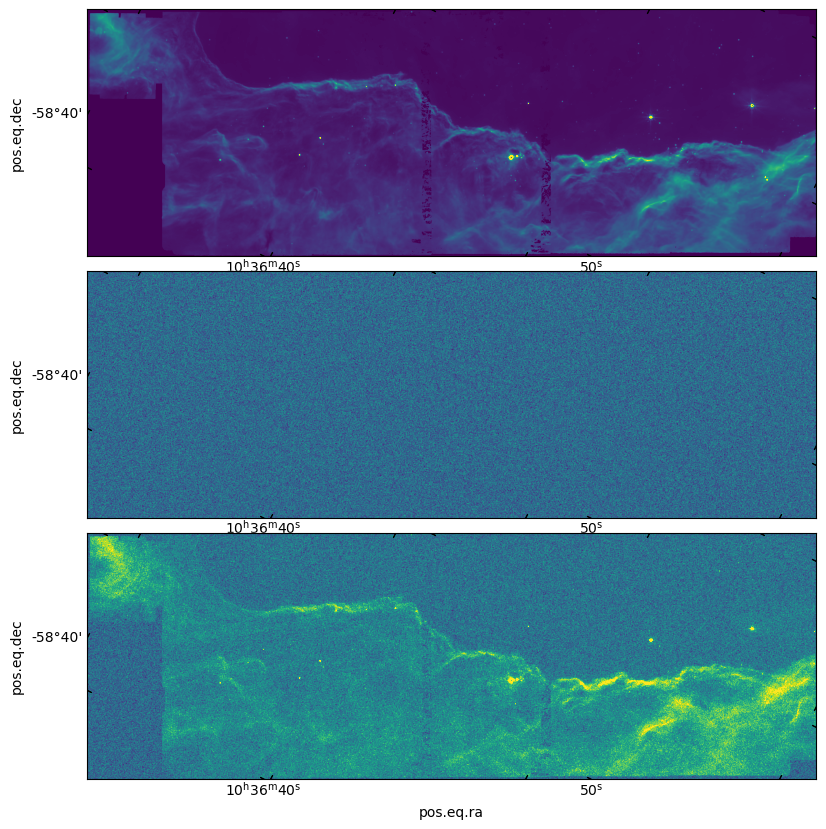

In [ ]:
sigma = calculated_sensitivity.to('MJy/sr').value
mean = 0 + sigma

gaussian_noise = np.random.normal(mean, sigma, (data.shape))*u.MJy/u.sr

noisy_image = data.value+gaussian_noise.value

plt.rcParams['figure.figsize'] = [18, 8]
inputs = [data,gaussian_noise,noisy_image]

fig = plt.figure()
for i in range(0,len(inputs)):
    ax = fig.add_subplot(3,1,i+1, projection=wcs)
    ax.imshow(inputs[i],vmin = vmin,vmax=vmax,origin='lower')
plt.tight_layout()